##Description

In this code, we develop a baseline model in the form of a logistic regression with three features. The performance of this model will be used as a point of comparison with the other machines

## Load the preprocessed data (refer to TJI_preprocessing.ipynb)

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [86]:
df = pd.read_csv('./preprocessed_TJI_deaths.csv')

##Split into races

In [87]:
print('Before dropping race OTHER: ', df.shape[0])
df = df[df['race']!='OTHER']
print('After dropping race OTHER: ', df.shape[0])
df_white = df[df['race']=='WHITE']
df_black = df[df['race']=='BLACK']
df_hispanic = df[df['race']=='HISPANIC']

Before dropping race OTHER:  10713
After dropping race OTHER:  10620


In [88]:
print('White prisoners: ', df_white.shape)
print('Black prisoners: ', df_black.shape)
print('Hispanic prisoners: ', df_hispanic.shape)

White prisoners:  (4609, 10)
Black prisoners:  (3120, 10)
Hispanic prisoners:  (2888, 10)


# White baseline model

First, create the features and label

In [118]:
df_white_Y = df_white['Natural']

df_white_X = df_white[['sex',
                       'age_at_time_of_death',
                       'Offense',]]

Split into validation and testing dataset

In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_white_X, df_white_Y, test_size=0.2)

We will need to develop a pipeline that will preprocess (scale + one-hot encode) if we want to use cross-validation. https://towardsdatascience.com/clean-efficient-data-pipelines-with-pythons-sklearn-2472de04c0ea

In [120]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), ['age_at_time_of_death']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['Offense']),
    ('binary', OrdinalEncoder(), ['sex'])
])

Define the model. Note that sklearn applies **regularization by default** (C=1)

In [121]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

Next, we will build the pipeline that will govern each iteration of cross validation

In [122]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('model', model)
])

Run 10-fold cross-validation. We may consider stratification

In [123]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

In [124]:
cv_results

array([0.85907859, 0.87533875, 0.88075881, 0.86178862, 0.87262873,
       0.84823848, 0.8699187 , 0.89130435, 0.8451087 , 0.88043478])

Perform GridSearchCV to find the best regularization penalty C (https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5)

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__penalty' : ['l2'],
    'model__C' : np.logspace(-4, 4, 20),
    'model__solver' : ['lbfgs','liblinear', 'saga']}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_)

best_model = gridsearch.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best hyperparameters: {'model__C': 0.03359818286283781, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


Check the encoding

In [126]:
#Check the one-hot encoding:
preprocess_pipeline = best_model.named_steps['preprocess']
one_hot = preprocess_pipeline.transformers_[1][1]

#Check the categories of the one-hot encoding:
categories_OH = one_hot.categories_

print(categories_OH[0])

#Check the ordinal encoding:
ordinal = preprocess_pipeline.transformers_[2][1]

categories_bin = ordinal.categories_

print(categories_bin[0])

#Check the label encoding:
model = best_model.named_steps['model']
print(model.classes_)

['Non-violent' 'Sexual' 'Violent']
['FEMALE' 'MALE']
['Natural' 'Unnatural']


The model assumes 'Unnatural' to be the positive class. Male is encoded as 1.

Check the weights

In [131]:
weights_white = best_model.named_steps['model'].coef_

numerical_col = ['Age']
categorical_col = categories_OH[0]
binary_col = ['Male']

col_names = numerical_col + list(categorical_col) + binary_col

coeff_df_white = pd.DataFrame(weights_white, columns = col_names, index = ['Unnatural causes'])
coeff_df_white = coeff_df_white.reset_index().rename(columns={'index': 'Cause'})
print(coeff_df_white)

              Cause       Age  Non-violent    Sexual  Violent      Male
0  Unnatural causes -1.548437    -0.001781 -0.224211  0.22654  0.009234


Evaluate using test data

In [129]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)

Test accuracy:  0.8785249457700651


Performance metrics

In [130]:
from sklearn.metrics import confusion_matrix, classification_report


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[728  12]
 [100  82]]
              precision    recall  f1-score   support

     Natural       0.88      0.98      0.93       740
   Unnatural       0.87      0.45      0.59       182

    accuracy                           0.88       922
   macro avg       0.88      0.72      0.76       922
weighted avg       0.88      0.88      0.86       922



# Black baseline model

In [132]:
df_black_X = df_black[['sex',
                       'age_at_time_of_death',
                       'Offense',]]

df_black_Y = df_black['Natural']

X_train, X_test, y_train, y_test = train_test_split(df_black_X, df_black_Y, test_size=0.2)

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), ['age_at_time_of_death']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['Offense']),
    ('binary', OrdinalEncoder(), ['sex'])
])

model_black = LogisticRegression()

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('model', model_black)
])

cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')


print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__penalty' : ['l2'],
    'model__C' : np.logspace(-4, 4, 20),
    'model__solver' : ['lbfgs','liblinear', 'saga']}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model = gridsearch.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)

CV-results:
 [0.86       0.88       0.868      0.888      0.892      0.868
 0.87951807 0.86345382 0.85943775 0.89558233] 
-------------------------------
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best hyperparameters: {'model__C': 0.615848211066026, 'model__penalty': 'l2', 'model__solver': 'lbfgs'} 
-------------------------------
Test accuracy:  0.8733974358974359


In [133]:
weights_black = best_model.named_steps['model'].coef_

numerical_col = ['Age']
categorical_col = categories_OH[0]
binary_col = ['Male']

col_names = numerical_col + list(categorical_col) + binary_col

coeff_df_black = pd.DataFrame(weights_black, columns = col_names, index = ['Unnatural causes'])
coeff_df_black = coeff_df_black.reset_index().rename(columns={'index': 'Cause'})
print(coeff_df_black)

              Cause       Age  Non-violent    Sexual   Violent      Male
0  Unnatural causes -1.379145     0.052465 -0.491128  0.442598  0.449301


In [134]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[522  24]
 [ 55  23]]
              precision    recall  f1-score   support

     Natural       0.90      0.96      0.93       546
   Unnatural       0.49      0.29      0.37        78

    accuracy                           0.87       624
   macro avg       0.70      0.63      0.65       624
weighted avg       0.85      0.87      0.86       624



# Hispanic baseline model

In [137]:
df_hispanic_X = df_hispanic[['sex',
                       'age_at_time_of_death',
                       'Offense',]]

df_hispanic_Y = df_hispanic['Natural']

X_train, X_test, y_train, y_test = train_test_split(df_hispanic_X, df_hispanic_Y, test_size=0.2)

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), ['age_at_time_of_death']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['Offense']),
    ('binary', OrdinalEncoder(), ['sex'])
])

model_hispanic = LogisticRegression()

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('model', model_hispanic)
])

cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__penalty' : ['l2'],
    'model__C' : np.logspace(-4, 4, 20),
    'model__solver' : ['lbfgs','liblinear', 'saga']}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model = gridsearch.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)

CV-results:
 [0.85714286 0.85714286 0.87445887 0.85281385 0.83116883 0.86147186
 0.87878788 0.86147186 0.85714286 0.87445887] 
-------------------------------
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best hyperparameters: {'model__C': 0.23357214690901212, 'model__penalty': 'l2', 'model__solver': 'liblinear'} 
-------------------------------
Test accuracy:  0.8737024221453287


In [142]:
weights_hisp = best_model.named_steps['model'].coef_

numerical_col = ['Age']
categorical_col = categories_OH[0]
binary_col = ['Male']

col_names = numerical_col + list(categorical_col) + binary_col

coeff_df_hisp = pd.DataFrame(weights_hisp, columns = col_names, index = ['Unnatural causes'])
coeff_df_hisp = coeff_df_hisp.reset_index().rename(columns={'index': 'Cause'})
print(coeff_df_hisp)

              Cause       Age  Non-violent    Sexual   Violent      Male
0  Unnatural causes -1.651998    -0.664021 -0.710284 -0.210269 -0.018605


In [139]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[456  24]
 [ 49  49]]
              precision    recall  f1-score   support

     Natural       0.90      0.95      0.93       480
   Unnatural       0.67      0.50      0.57        98

    accuracy                           0.87       578
   macro avg       0.79      0.72      0.75       578
weighted avg       0.86      0.87      0.87       578



# Dummy classifier

The Black machine struggles quite a bit. As a comparison, let's try using a dummy classifier with strategy set to 'stratified'

In [152]:
from sklearn.dummy import DummyClassifier

df_black_X = df_black[['sex',
                       'age_at_time_of_death',
                       'Offense',]]

df_black_Y = df_black['Natural']

X_train, X_test, y_train, y_test = train_test_split(df_black_X, df_black_Y, test_size=0.2)

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), ['age_at_time_of_death']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['Offense']),
    ('binary', OrdinalEncoder(), ['sex'])
])

dummy_model = DummyClassifier(strategy='stratified')

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('model', dummy_model)
])

cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

dummy_model.fit(X_train, y_train)

pred = dummy_model.predict(X_test)

accuracy = accuracy_score(y_test, pred)

print('Test accuracy: ', accuracy)


CV-results:
 [0.732      0.744      0.78       0.744      0.736      0.812
 0.75903614 0.76706827 0.76706827 0.72690763] 
-------------------------------
Test accuracy:  0.7788461538461539


In [153]:
conf_matrix = confusion_matrix(y_test, pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, pred))

Confusion matrix:
 [[475  72]
 [ 66  11]]
              precision    recall  f1-score   support

     Natural       0.88      0.87      0.87       547
   Unnatural       0.13      0.14      0.14        77

    accuracy                           0.78       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.79      0.78      0.78       624



#Visualize weights

In [140]:
def visualize_weights(df_white, df_black, df_hisp):

  #Melt each dataframe into a long format
  df_white_melt = df_white.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Weight')
  df_black_melt = df_black.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Weight')
  df_hisp_melt = df_hisp.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Weight')

  #Add race to long dfs
  df_white_melt['race'] = 'White'
  df_black_melt['race'] = 'Black'
  df_hisp_melt['race'] = 'Hispanic'

  #Combine the long dfs
  df_vis = pd.concat([df_white_melt, df_black_melt, df_hisp_melt])

  causes = df_vis['Cause'].unique()

  for cause in causes:

    cause_df = df_vis[df_vis['Cause']==cause]

    sns.barplot(x='Feature', y='Weight', hue='race',
              data=cause_df, ci=None, palette='muted')

    plt.title(f'Death by {cause}')

    plt.axhline(y=0)

    plt.xticks(rotation=90)

    plt.show()

<ipython-input-140-55b792eb2993>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Feature', y='Weight', hue='race',


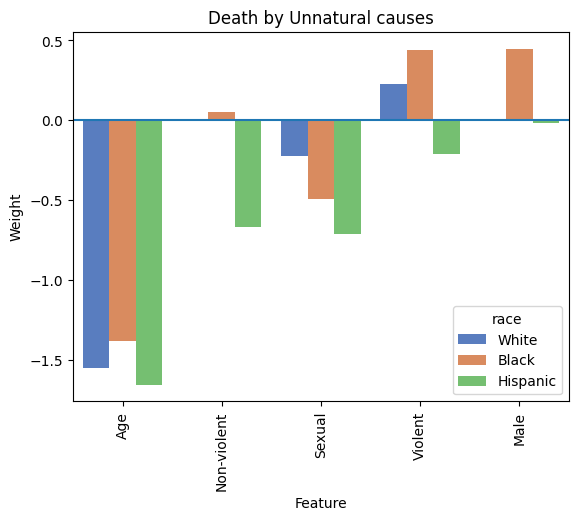

In [143]:
visualize_weights(coeff_df_white, coeff_df_black, coeff_df_hisp)

As expected, the older you are, the more likely you are to die of natural causes–this holds true for all races. Hispanic prisoners are uniquely less likely to die of unnatural causes if they committed a violet crime. Black males are also much more likely to die of unnatural causes.

#General remarks

All machines currently struggle with recall. The Black machine (and to a lesser extent, the Hispanic machine) also struggles with precision, though it performs better than a dummy classifier. This is likely due to class imbalance. This will serve as the baseline problem to overcome for this study.